In [1]:
import os
import argparse
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
from model import Unet, CoSeDif
# from accelerate import Accelerator
import skimage.io as io
from PIL import Image 


## Parse CLI arguments ##
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('-od', '--output_dir', type=str, default="output", help="Output dir.")
    parser.add_argument('-ld', '--logging_dir', type=str, default="logs", help="Logging dir.")
    parser.add_argument('-mp', '--mixed_precision', type=str, default="bf16", choices=["no", "fp16", "bf16"],
                        help="Whether to do mixed precision")
   
 
    parser.add_argument('-ic', '--mask_channels', type=int, default=1, help='input channels for training (default: 3)')
    parser.add_argument('-c', '--input_img_channels', type=int, default=1,
                        help='output channels for training (default: 3)')
    parser.add_argument('-is', '--image_size', type=int, default=128, help='input image size (default: 128)')
    parser.add_argument('-d', '--dim', type=int, default=64, help='dim (default: 64)')
    parser.add_argument('-e', '--epochs', type=int, default=10000, help='number of epochs (default: 10000)')
    parser.add_argument('-bs', '--batch_size', type=int, default=8, help='batch size to train on (default: 8)')
    parser.add_argument('--timesteps', type=int, default=1000, help='number of timesteps (default: 1000)')
    parser.add_argument('-ds', '--dataset', default='seismic', help='Dataset to use')
    args, unknown = parser.parse_known_args()
    
    return args






    




In [2]:
args = parse_args()
logging_dir = os.path.join(args.output_dir, args.logging_dir)
inference_dir = os.path.join(args.output_dir, 'inference')
os.makedirs(inference_dir, exist_ok=True)
# accelerator = Accelerator(
#     mixed_precision=args.mixed_precision,
# )
# if accelerator.is_main_process:
#     accelerator.init_trackers("med-seg-diff", config=vars(args))

## DEFINE MODEL ##
model = Unet(
    dim=args.dim,
    image_size=args.image_size,
    dim_mults=(1, 2, 4, 8),
    mask_channels=args.mask_channels,
    input_img_channels=args.input_img_channels,
    self_condition=False
)



diffusion = CoSeDif(
    model,
    timesteps=args.timesteps,
    sampling_timesteps=100
)
# ).to(accelerator.device)

save_dict = torch.load(r'C:\Users\soufiene\OneDrive\Documents\pfe\lol\with_layers\FaultDiff.pt')
diffusion.model.load_state_dict(save_dict['model_state_dict'])
print('model_loaded')


    



model_loaded


# Inference

(1, 128, 128)


(-0.5, 127.5, 127.5, -0.5)

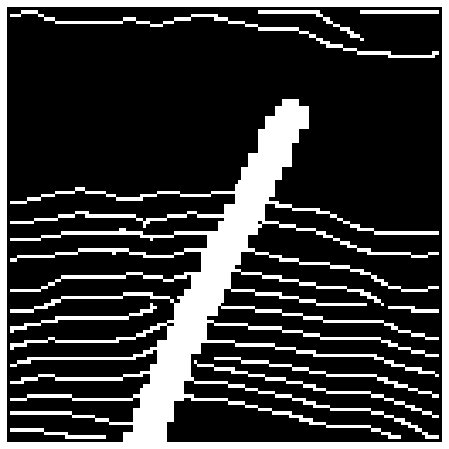

In [3]:
import numpy as np
import torch
edges=np.load(r'C:\Users\soufiene\OneDrive\Documents\pfe\dataset_for_unet\test\condition\edges\10.npy')
image=np.load(r'C:\Users\soufiene\OneDrive\Documents\pfe\dataset_for_unet\test\real_images\10.npy')
print(image.shape)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

# Display the condition
plt.imshow(edges[0],cmap='gray')
plt.axis('off')  # Turn off axis labels and ticks



In [4]:
edges=np.expand_dims(edges, axis=0)
edges=torch.tensor(edges)
print(edges.shape)

torch.Size([1, 1, 128, 128])


In [5]:
# preds = torch.zeros((edges.shape[0], 5, edges.shape[2], edges.shape[3]))
# for i in range(5):
#         preds[:, i:i+1, :, :] = diffusion.sample(edges).cpu().detach()
pred=diffusion.sample(edges).cpu().detach()
     

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

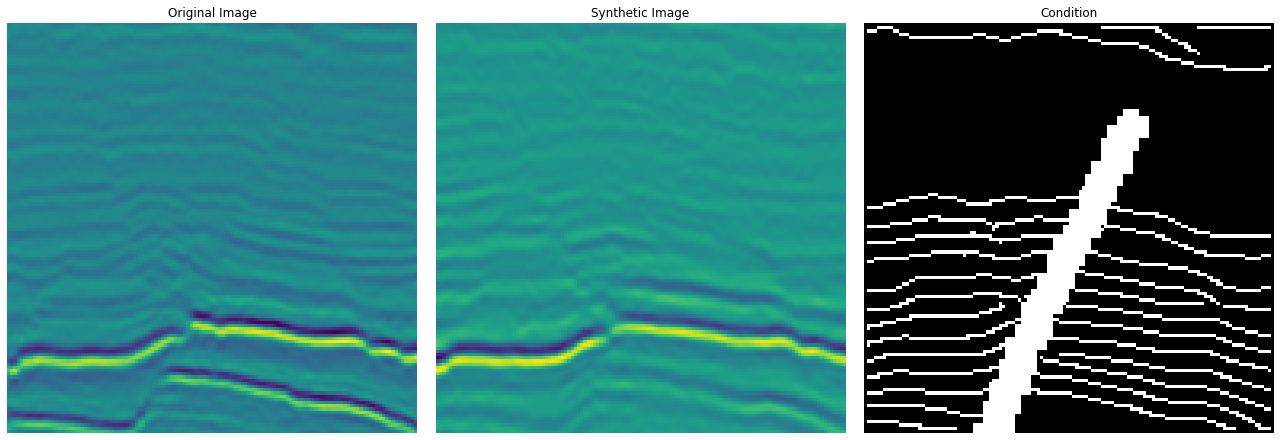

In [6]:


# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the original image
axes[0].imshow(image[0])
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot the synthetic image
axes[1].imshow(pred[0][0])
axes[1].set_title('Synthetic Image')
axes[1].axis('off')

# Plot the condition (edges)
axes[2].imshow(edges[0][0],cmap='gray')
axes[2].set_title('Condition')
axes[2].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio
from sklearn.metrics import mean_squared_error

# Convert images to numpy arrays (assuming pred[0][0] and image[0] are numpy arrays)
synthetic_image = np.array(pred[0][0])
real_image = np.array(image[0])

def calculate_dssim(img1, img2):
    """Calculate Structural Dissimilarity Index."""
    ssim_value = ssim(img1, img2, data_range=1, multichannel=True)
    dssim = (1 - ssim_value) / 2
    return dssim

# Calculate MSE using sklearn
mse = mean_squared_error(real_image.flatten(), synthetic_image.flatten())

# Calculate PSNR using skimage
psnr_value = peak_signal_noise_ratio(real_image, synthetic_image, data_range=1)

# Calculate DSSIM
dssim_value = calculate_dssim(real_image, synthetic_image)

print(f"Peak Signal-to-Noise Ratio: {psnr_value:.2f} dB")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Structural Dissimilarity Index: {dssim_value:.4f}")


Peak Signal-to-Noise Ratio: 26.50 dB
Mean Squared Error: 0.0022
Structural Dissimilarity Index: 0.1708


C:\Users\soufiene\AppData\Local\Temp\ipykernel_2068\491141632.py:11: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(img1, img2, data_range=1, multichannel=True)


# Testing the genereated images from the held out training

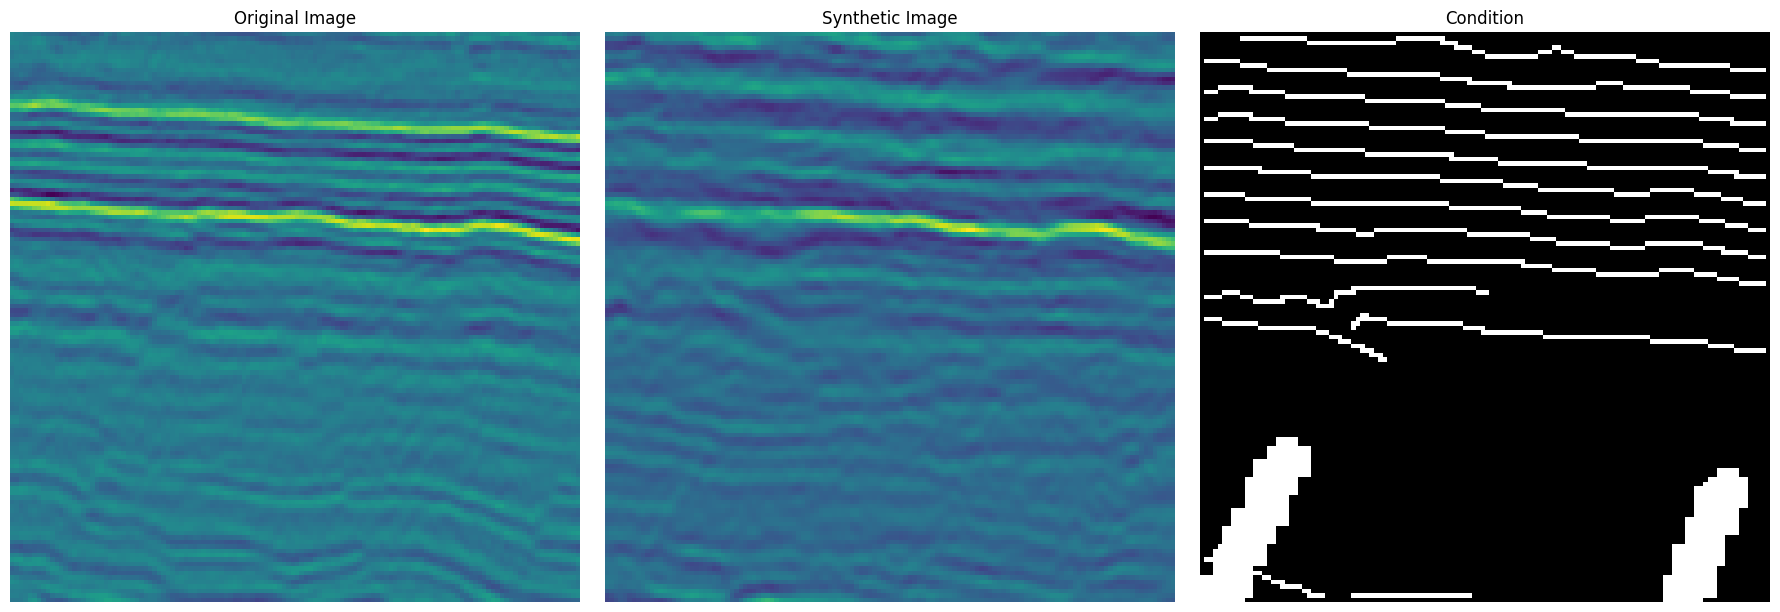

In [22]:
import numpy as np
import matplotlib.pyplot as plt
image=np.load('/home/b4-13/intern/dataset_for_unet/test_800/images/0.npy')
pred=np.load('/home/b4-13/intern/dataset_for_unet/test_800/synthetic/0.npy')
edges=np.load('/home/b4-13/intern/dataset_for_unet/test_800/edges/0.npy')

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the original image
axes[0].imshow(image[0])
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot the synthetic image
axes[1].imshow(pred)
axes[1].set_title('Synthetic Image')
axes[1].axis('off')

# Plot the condition (edges)
axes[2].imshow(edges[0],cmap='gray')
axes[2].set_title('Condition')
axes[2].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [23]:
#Calculating metrics for one image 
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio
from sklearn.metrics import mean_squared_error

# Assuming `pred` and `image` are numpy arrays
image = np.array(image[0])
pred = np.array(pred)  # Ensure `pred` is a numpy array

def calculate_dssim(img1, img2):
    """Calculate Structural Dissimilarity Index."""
    ssim_value = ssim(img1, img2, data_range=1, multichannel=False)
    dssim = (1 - ssim_value) / 2
    return dssim

# Calculate MSE using sklearn
mse = mean_squared_error(image.flatten(), pred.flatten())

# Calculate PSNR using skimage
psnr_value = peak_signal_noise_ratio(image, pred, data_range=1)

# Calculate DSSIM
dssim_value = calculate_dssim(image, pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Structural Dissimilarity Index: {dssim_value:.4f}")
print(f"Peak Signal-to-Noise Ratio: {psnr_value:.2f} dB")


Mean Squared Error: 0.0018
Structural Dissimilarity Index: 0.1979
Peak Signal-to-Noise Ratio: 27.55 dB


In [24]:
#Calculate metrics for all dataset 
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio
from sklearn.metrics import mean_squared_error

def calculate_dssim(img1, img2):
    """Calculate Structural Dissimilarity Index."""
    ssim_value = ssim(img1, img2, data_range=1, multichannel=False)
    dssim = (1 - ssim_value) / 2
    return dssim

def process_image(synthetic_image_path, real_image_path):
    """Process and compare a pair of images."""
    
    # Load real image
    real_image = np.load(real_image_path)
    real_image = real_image[0]  # Assuming the first element is the image array
    
    # Load synthetic image
    synthetic_image = np.load(synthetic_image_path)
    
    # Ensure images are in the same format and range
    # Assuming images are normalized between 0 and 1
    # If not, you may need to normalize here: synthetic_image = synthetic_image / 255.0
    
    # Calculate metrics
    mse = mean_squared_error(real_image.flatten(), synthetic_image.flatten())
    psnr = peak_signal_noise_ratio(real_image, synthetic_image, data_range=1)
    dssim = calculate_dssim(real_image, synthetic_image)
    
    return mse, psnr, dssim

def process_folder(synthetic_folder, real_folder):
    """Process all image pairs in the folder."""
    mse_values = []
    psnr_values = []
    dssim_values = []
    
    for filename in os.listdir(synthetic_folder):
        if filename.endswith('.npy'):  # Add or remove file extensions as needed
            synthetic_path = os.path.join(synthetic_folder, filename)
            real_path = os.path.join(real_folder, filename)  # Assuming matching filenames
            
            if os.path.exists(real_path):
                mse, psnr, dssim = process_image(synthetic_path, real_path)
                mse_values.append(mse)
                psnr_values.append(psnr)
                dssim_values.append(dssim)
            else:
                print(f"Skipping {filename}: No matching real image found")
    
    # Calculate average metrics
    avg_mse = np.mean(mse_values) if mse_values else float('nan')
    avg_psnr = np.mean(psnr_values) if psnr_values else float('nan')
    avg_dssim = np.mean(dssim_values) if dssim_values else float('nan')
    
    print(f"\nAverage MSE: {avg_mse:.4f}")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average DSSIM: {avg_dssim:.4f}")
    
    return mse_values, psnr_values, dssim_values

synthetic_folder = '/home/b4-13/intern/dataset_for_unet/test_800/synthetic'
real_folder = '/home/b4-13/intern/dataset_for_unet/test_800/images'
mse_values, psnr_values, dssim_values = process_folder(synthetic_folder, real_folder)



Average MSE: 0.0028
Average PSNR: 26.74 dB
Average DSSIM: 0.1905


In [274]:
##### For dinoooo

import os

# Specify the folder path and the output text file path
folder_path = '/home/b4-13/intern/512x512/val/images'
output_file_path = '/home/b4-13/intern/DinoBloom-main/DinoBloom-main/path.txt'

# Get all file paths in the folder
file_paths = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_paths.append(file_path)

# Write the file paths to the text file
with open(output_file_path, 'w') as f:
    for file_path in file_paths:
        f.write(f"{file_path}\n")

print(f"Paths of all files in '{folder_path}' have been written to '{output_file_path}'.")


Paths of all files in '/home/b4-13/intern/512x512/val/images' have been written to '/home/b4-13/intern/DinoBloom-main/DinoBloom-main/path.txt'.


In [6]:
import os

# Specify the path to the folder
folder_path = "/home/b4-13/intern/full_dataset/test/masks"

# Get the list of files in the folder
files = os.listdir(folder_path)

# Count the number of files
num_files = len(files)

print(f"Number of files in the folder: {num_files}")

Number of files in the folder: 127497


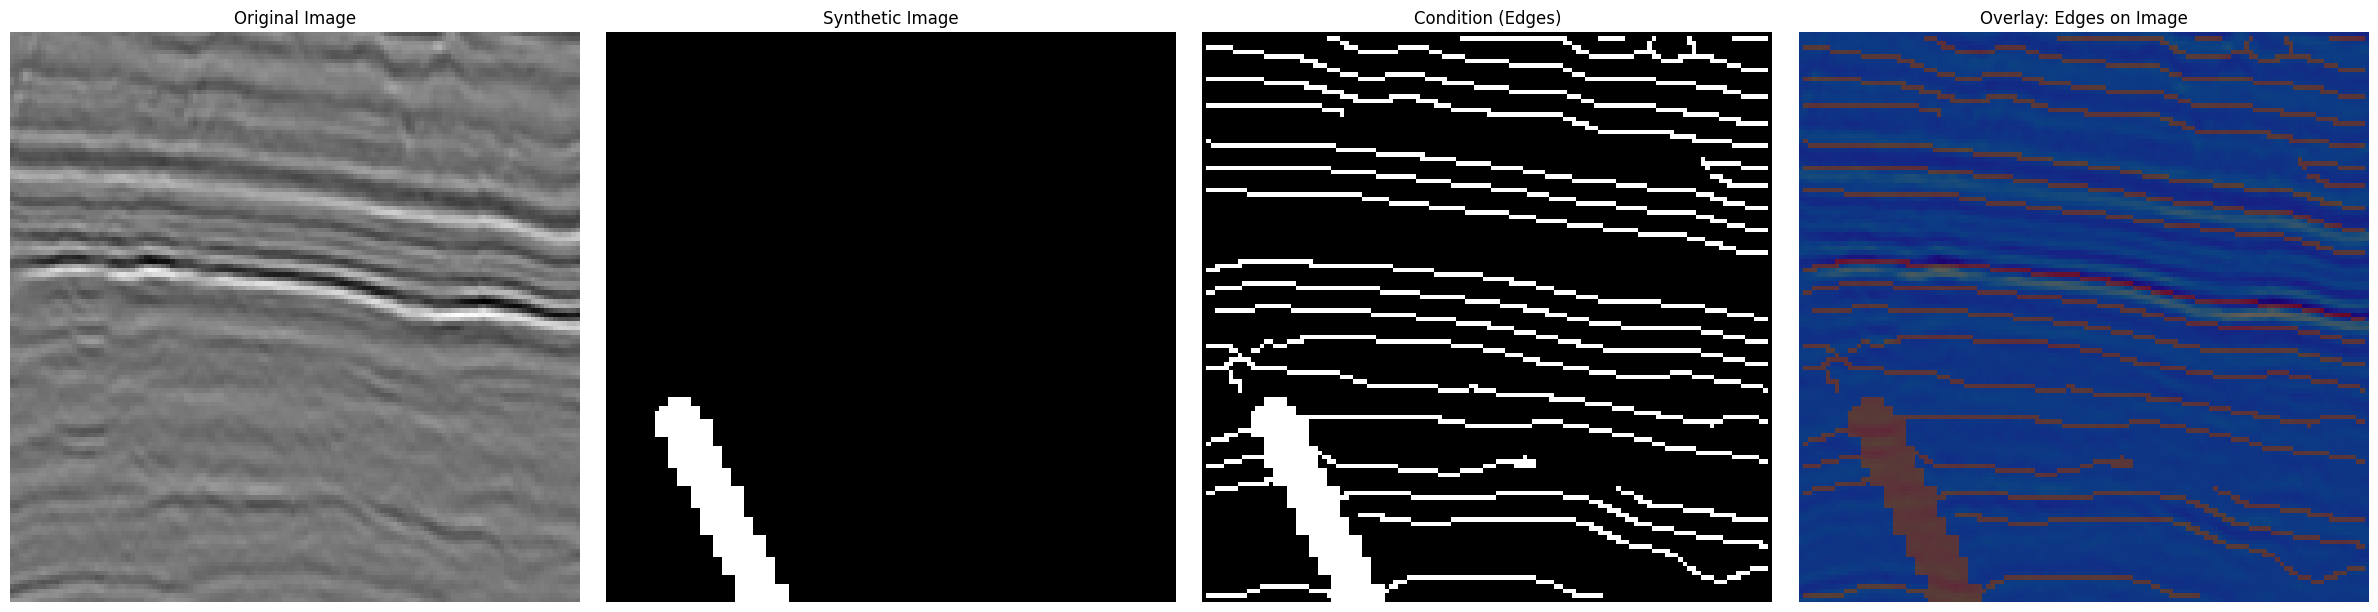

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load the images and edges
image = np.load('/home/b4-13/intern/full_dataset/train/images/5.npy')
pred = np.load('/home/b4-13/intern/full_dataset/train/masks/5.npy')
edges = np.load('/home/b4-13/intern/full_dataset/train/edges/5.npy')

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot the original image
axes[0].imshow(image[0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot the synthetic image
axes[1].imshow(pred[0], cmap='gray')
axes[1].set_title('Synthetic Image')
axes[1].axis('off')

# Plot the condition (edges)
axes[2].imshow(edges[0], cmap='gray')
axes[2].set_title('Condition (Edges)')
axes[2].axis('off')

# Overlay the edges on the original image with cmap 'jet' and alpha blending
axes[3].imshow(image[0])
axes[3].imshow(edges[0], cmap='jet', alpha=0.6)  # Adjust alpha for transparency
axes[3].set_title('Overlay: Edges on Image')
axes[3].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
